# Lyrics to genres multi-label classification

### Data loading and preparing

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [42]:
data = pd.read_csv(r"data_cleaned/final.csv")

In [43]:
data.head()

,genre,lyrics
0,new jack swing,"NA Yeah, Spyderman and Freeze in full effect U..."
1,neo soul,I really can't stay Baby it's cold outside I'v...
2,dance pop,Get up out of my business You don't keep me fr...
3,urban contemporary,"Hold your breath, don't look down, keep trying..."
4,new jack swing,All I want is somebody who's gonna love me for...


In [47]:
unique_genres = set()

for row in data.genre:
    for item in row.split(","):
        unique_genres.add(item)

print(unique_genres)

{'alternative rock', 'new age', 'electro', 'gothic metal', 'electronic', 'power metal', 'trance', 'reggae', 'chillout', 'industrial', 'k-rock', 'metal', 'ska', 'house', 'classic rock', 'j-pop', 'doom metal', 'progressive rock', 'punk', 'psychedelic', 'folk rock', 'electropop', 'progressive metal', 'instrumental', 'pop', 'downtempo', 'post-rock', 'r&b', 'urban contemporary', 'country', 'indie folk', 'metalcore', 'permanent wave', 'singer-songwriter', 'death metal', 'dance pop', 'punk rock', 'k-pop', 'pop punk', 'black music', 'jazz', 'piano rock', 'power-pop', 'thrash metal', 'alternative metal', 'indie rock', 'grunge', 'psychedelic rock', 'neo soul', 'disco', 'black metal', 'blues', 'indie', 'soundtrack', 'hip hop', 'nu metal', 'pop rock', 'hard rock', 'post-hardcore', 'new jack swing', 'child music', 'dance', 'lo-fi', 'ambient', 'rock', 'soul', 'britpop', 'soft rock', 'edm', 'melodic death metal', 'j-rock', 'post-punk', 'classical', 'world music', 'trip-hop', 'heavy metal', 'emo', 'te

In [45]:
def get_new_genres(df):
    genres = dict()
    
    for row in df.genre:
        for item in row.split(","):
            if item in genres:
                genres[item] += 1
            else:
                genres[item] = 1
    
    return genres

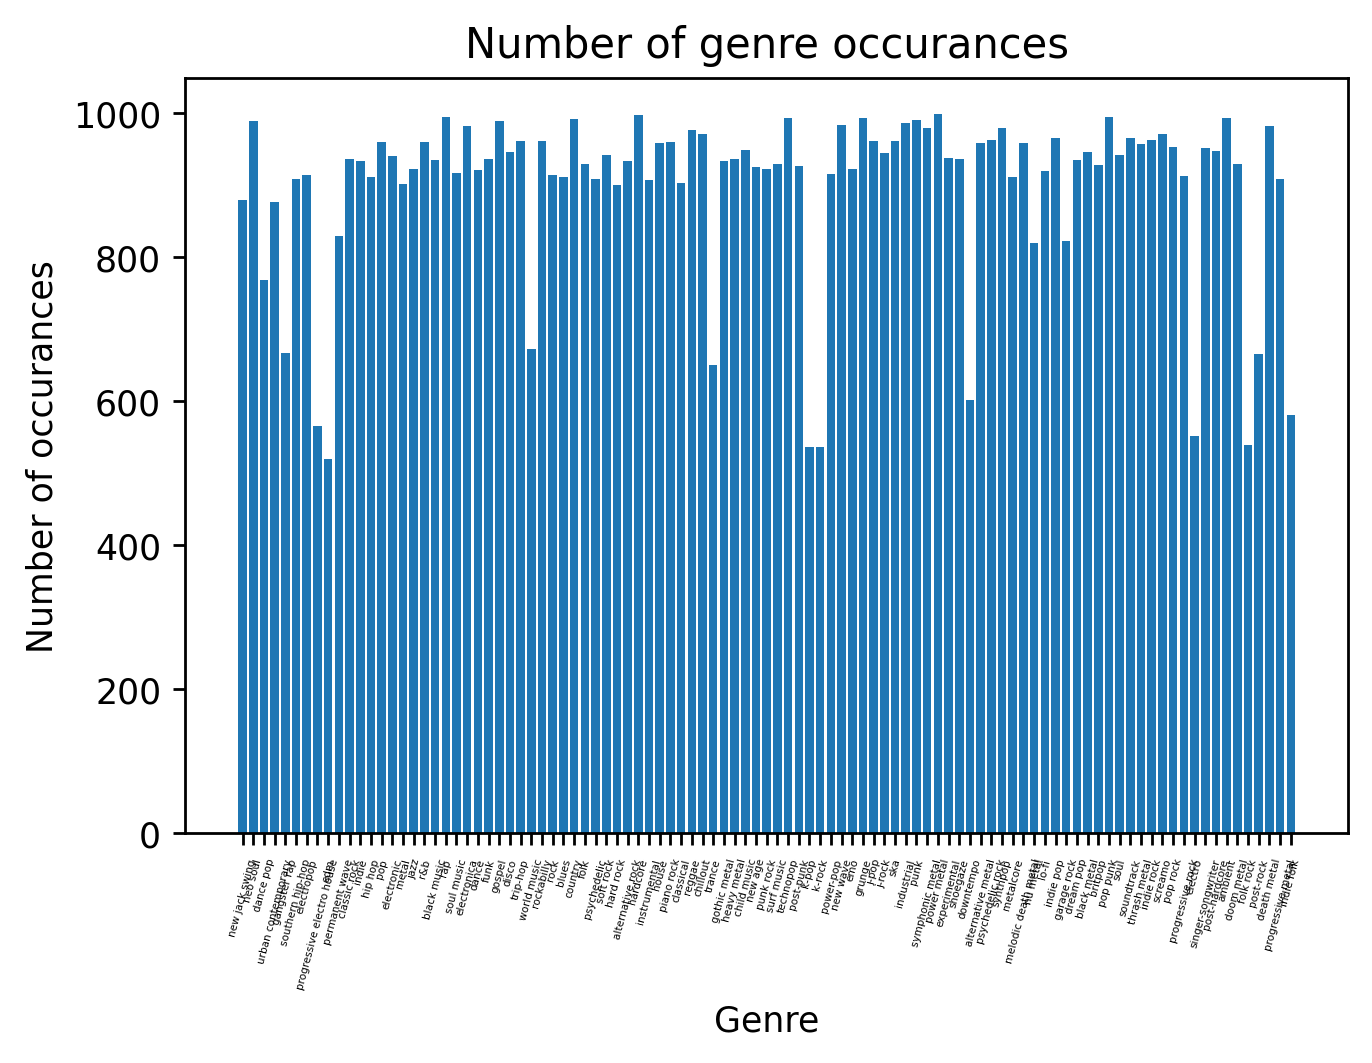

In [46]:
genres = get_new_genres(data)

plt.figure(dpi=250)
plt.bar(genres.keys(), genres.values())
plt.title("Number of genre occurances")
plt.ylabel ('Number of occurances')
plt.xlabel ('Genre')
plt.xticks(list(genres.keys()), rotation=75, fontsize=3)
plt.show()

In [56]:
unique_genres = list(unique_genres)
unique_genres

['alternative rock',
 'new age',
 'electro',
 'gothic metal',
 'electronic',
 'power metal',
 'trance',
 'reggae',
 'chillout',
 'industrial',
 'k-rock',
 'metal',
 'ska',
 'house',
 'classic rock',
 'j-pop',
 'doom metal',
 'progressive rock',
 'punk',
 'psychedelic',
 'folk rock',
 'electropop',
 'progressive metal',
 'instrumental',
 'pop',
 'downtempo',
 'post-rock',
 'r&b',
 'urban contemporary',
 'country',
 'indie folk',
 'metalcore',
 'permanent wave',
 'singer-songwriter',
 'death metal',
 'dance pop',
 'punk rock',
 'k-pop',
 'pop punk',
 'black music',
 'jazz',
 'piano rock',
 'power-pop',
 'thrash metal',
 'alternative metal',
 'indie rock',
 'grunge',
 'psychedelic rock',
 'neo soul',
 'disco',
 'black metal',
 'blues',
 'indie',
 'soundtrack',
 'hip hop',
 'nu metal',
 'pop rock',
 'hard rock',
 'post-hardcore',
 'new jack swing',
 'child music',
 'dance',
 'lo-fi',
 'ambient',
 'rock',
 'soul',
 'britpop',
 'soft rock',
 'edm',
 'melodic death metal',
 'j-rock',
 'post-p

In [82]:
def set_labels(df):
    labels = np.array([0 for i in range(len(unique_genres))])

    for item in row.split(","):
        labels[unique_genres.index(item)] = 1
    
    return labels

In [83]:
data["labels"] = data["genre"].apply(lambda x: set_labels(x))

In [80]:
data.head()

,genre,lyrics,labels
0,new jack swing,"NA Yeah, Spyderman and Freeze in full effect U...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,neo soul,I really can't stay Baby it's cold outside I'v...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dance pop,Get up out of my business You don't keep me fr...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,urban contemporary,"Hold your breath, don't look down, keep trying...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,new jack swing,All I want is somebody who's gonna love me for...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [98]:
# data["genre"][0]
# unique_genres[list(data["labels"][0]).index(1)]
for i in range(len(list(data["labels"][0]))):
    if list(data["labels"][0])[i]==1:
        print(i)

51
65


In [100]:
unique_genres[51]

'blues'